# Multiple Linear Regression - Advertising Budget Optimization

### In this problem, we are given a dataset consisting of three predictors (money spent on tv, radio, and newspaper advertising in thousands of dollars) and one response (sales in millions of dollars). The goal of this project is create the best linear regression model given these predictors. This linear model will then be used to maximize predicted sales by optimizing budget allocation.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold, RepeatedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations, combinations_with_replacement
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.optimize import minimize

# import the data
raw = pd.read_csv('Advertising.csv').iloc[:, 1:]
raw.columns = ['tv', 'radio', 'newspaper', 'sales']
raw.head()

,tv,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [83]:
raw.describe()

,tv,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


## Data Exploration

### First, we create a scatterplot for each predictor vs. the response to get a general idea of the relationship between them.

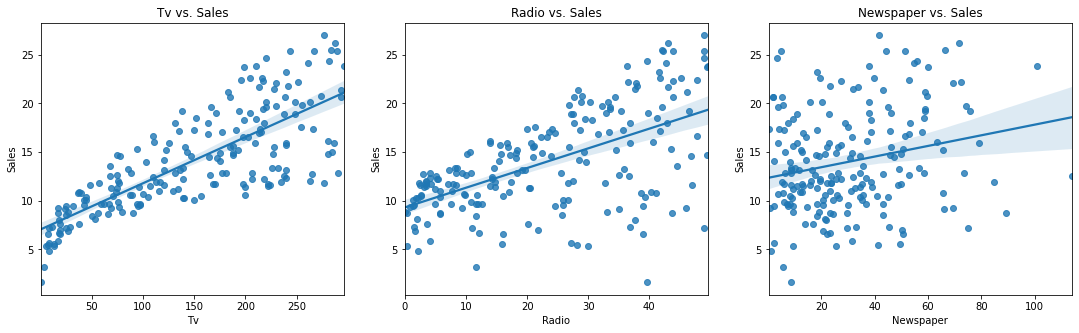

In [84]:
def make_plots(df):
    plt.figure(figsize=(25, 5))

    for n, col in enumerate(df.columns[:-1]):
        ax = plt.subplot(1, df.shape[1], n+1)

        sns.regplot(x=df[col], y=df[list(df.columns)[-1]], ax=ax)

        ax.set_title(col.capitalize() + ' vs. Sales')
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('Sales')

    plt.show()

    return

make_plots(raw)

### From the plots above, we can see that there is an approximately linear relationship between at least some of the predictors and the repsonse, indicating that a linear model may be a good fit for our data. 

### TV Advertising appears to be the best predictor of Sales, followed by Radio Advertising, and finally Newspaper Advertising. We can verify this by printing out the correlation matrix below.

In [85]:
print('Correlation Matrix:\n\n', raw.corr())

Correlation Matrix:

                  tv     radio  newspaper     sales
tv         1.000000  0.054809   0.056648  0.782224
radio      0.054809  1.000000   0.354104  0.576223
newspaper  0.056648  0.354104   1.000000  0.228299
sales      0.782224  0.576223   0.228299  1.000000


### We can also see from the correlation matrix that the predictors are not overly correlated with eachother (which is an assumption of our linear model). This means we likely will not have to deal with multicollineary between the predictors. We can verify this by analyzing the VIF (variation inflation factor) of each of these predictors. 

In [86]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif['predictors'] = df.columns
    vif['vif'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif

vif = calc_vif(raw.iloc[:, :-1])
vif

,predictors,vif
0,tv,2.486772
1,radio,3.285462
2,newspaper,3.055245


### All of the VIFs are less than 5, indicating little multicollinearity between the predictors. 

### Before we start building models, let's remove any outlier samples. We'll remove any samples where the value for any predictor is larger than 3 standard deviations away from the mean of that predictor.

In [87]:
raw = raw[(np.abs(stats.zscore(raw)) < 3).all(axis=1)]
print('Number of non-outlier samples: ', raw.shape[0])

Number of non-outlier samples:  198


### Our original dataset had 200 rows. We have removed 2 outlier samples.

## Creating a Baseline

### We'll now run an Ordinary Least Squares Regression on the dataset. Here we are regressing Sales onto the three predictor variables to establish a baseline. Our goal for this project is to build a model that outperforms this baseline. We'll be using R-squared as our primary performance indicator.

In [88]:
# defining our performance indicator
def r2(y_actual, y_predicted):
    y_actual = np.array(y_actual)  
    y_predicted = np.array(y_predicted)
    
    sst = np.sum((y_actual - y_actual.mean())**2)
    ssr = np.sum((y_predicted - y_actual)**2)
    r2_score = 1 - (ssr/sst)

    return round(r2_score, 3)

# function that scales the predictors using MinMaxScaler(), implements OLS, and predicts using X_test 
def linreg(df, scale=False):         
    X = df.iloc[:, :-1]
    y = list(df.iloc[:, -1])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=20)

    if scale:
        scaler = MinMaxScaler() # scaling our features is not neccessary, but it helps with model efficiency
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X.columns))
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=list(X.columns))

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    ols = sm.OLS(y_train, X_train).fit()
    linreg.summary = ols.summary()
    linreg.coefs = ols.params
    linreg.y_pred = ols.predict(X_test)
    linreg.y_test = y_test
    linreg.resid = np.subtract(np.array(linreg.y_test), np.array(linreg.y_pred))
    linreg.r2 = r2(linreg.y_test, linreg.y_pred)
    
    return

In [89]:
# running the linear regression model on the raw data
linreg(raw, scale=True)
print(f'The R-squared on the test data is: {linreg.r2}\n\n', linreg.summary)

The R-squared on the test data is: 0.912

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     377.2
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           5.65e-68
Time:                        16:55:36   Log-Likelihood:                -284.61
No. Observations:                 148   AIC:                             577.2
Df Residuals:                     144   BIC:                             589.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

### This baseline model achieves an R-squared score of .912 on the test data. 

### Another thing to note is that the p-value for the Newspaper advertising predictor is much larger than .05 and its coefficient is nearly 0. This indicates that Newpaper advertising may not be an effective predictor for Sales.

## Interactions

### Before we start feature selection, let's create interaction variables. To keep things simple for explanatory purposes, we're only going to look at interactions of order 2, though this could be increased for more complex datasets.

In [90]:
def create_interactions(input_df, order=None):
    """
    Outputs a new df that includes a column for all interaction terms up to the specified order.
 
    Args:
        input_df: A df with n columns where the first n-1 columns are predictors and the n-th column is a response  
        order: The maximum number of features multiplied together in the interaction terms (i.e if [x0, x1] are the original predictors and order = 2, then the new predictors will be [x0, x1, x0**2, x0*x1, x1**2]). If order=None, then the maximum order of the interaction terms is equal to the number of predictors in the input_df.

    Returns: 
        A df that includes a new column for every interaction term up to the specified order with the response variable as the last column
    """
    response_name = list(input_df.columns)[-1]
    df = input_df.iloc[:, :-1]
    response = input_df.iloc[:, -1]

    attrs = list(df.columns)
    combs = []

    if order == None:
        max_terms = len(attrs) + 1
    else:
        max_terms = order + 1

    for n in range(2, max_terms):
        combs.append([i for i in combinations_with_replacement(attrs, n)])

    combs = [item for sublist in combs for item in sublist]

    for i in combs:
        new_col_name = "*".join(i)
        new_col_vals = df[i[0]]

        for j in range(1, len(i)):
            new_col_vals = new_col_vals * df[i[j]]

        df[new_col_name] = new_col_vals

    df[response_name] = response

    return df

In [91]:
df = create_interactions(raw, order=2)
df.head()

,tv,radio,newspaper,tv*tv,tv*radio,tv*newspaper,radio*radio,radio*newspaper,newspaper*newspaper,sales
0,230.1,37.8,69.2,52946.01,8697.78,15922.92,1428.84,2615.76,4788.64,22.1
1,44.5,39.3,45.1,1980.25,1748.85,2006.95,1544.49,1772.43,2034.01,10.4
2,17.2,45.9,69.3,295.84,789.48,1191.96,2106.81,3180.87,4802.49,9.3
3,151.5,41.3,58.5,22952.25,6256.95,8862.75,1705.69,2416.05,3422.25,18.5
4,180.8,10.8,58.4,32688.64,1952.64,10558.72,116.64,630.72,3410.56,12.9


### Our new datafram has 6 new columns for each interaction of order 2. We now have 9 predictors along with our original response variable.

### Here we are going to use sklearn's LinearRegression() so we can take advantage of RFECV (Recursive Feature Elimination with Cross Validation) and automatically elimate the least import features that would likely cause overfitting. RFECV uses cross validation to automatically select the optimal number of predictors to use in our linear regression model in each iteration. We'll keep track of which predictors the model uses in each iteration to build the final model.

In [92]:
# split the data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# create pipeline
scaler = MinMaxScaler() # scaling is not neccessary, but helps with model efficiency
rfe = RFECV(estimator=LinearRegression())
model = LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('rfe', rfe), ('model', model)])

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=27)
result = cross_validate(pipe, X, y, scoring='r2', cv=cv, return_estimator=True, n_jobs=-1, error_score='raise')

avg_r2 = np.mean(np.array(result['test_score']))
print(f'Average R-squared Score: {round(avg_r2, 3)}')

Average R-squared Score: 0.983


### The average R-squared for our new model is around .983, which is a significant improvement over our baseline of .912.

## Feature Selection

### Now let's take a look at how many predictors, *p*, the model used in each iteration. We'll also look at which predictors the model used and use RFECV's built-in attribute *ranking_* to identify the top *p* predictors of Sales.  

In [93]:
# look through each iteration of the model and keep track of which features were used and how many were used
feature_rank = pd.DataFrame(columns = X.columns)

num_features = []
for iter, pipe in enumerate(result['estimator']):
    rank = []
    num_features.append(pipe['rfe'].n_features_)
    for i in range(X.shape[1]):
        rank.append(pipe['rfe'].ranking_[i])

    feature_rank.loc[len(feature_rank)] = rank

In [94]:
# look at some basic statistical metrics for the number of features were used to see if we can confidently identify the amount of features to use in our model
num_features = np.array(num_features)

mean = np.mean(num_features)
median = np.median(num_features)
most_common = stats.mode(num_features)[0][0]
p = math.floor(np.mean([mean, median, most_common]))

print(f'Mean: {mean}')
print(f'Median: {median}')
print(f'Mode: {most_common}')
print(f'The number of predictors to use in model, p: {p}')

Mean: 5.766666666666667
Median: 6.0
Mode: 4
The number of predictors to use in model, p: 5


### The mean, median, and mode of the number of features the model opted to use in each iteration are all between 4 and 6. I've decided to use 5 - the average of the mean, median, and mode rounded down to the nearest integer - as the number of features we will use in the next version of our model.

### Now we are going to use RFECV's built-in attribute *ranking_* to select the top 5 most important features for our model.

In [95]:
# looks at the top p most used features and the top p with the lowest rank
features = list(pd.DataFrame(feature_rank.sum(axis=0).sort_values().head(p)).T.columns)

print(f'The top {p} most important features are: {", ".join(features)}')

The top 5 most important features are: tv, radio, tv*tv, tv*radio, tv*newspaper


### Now that we have our 5 most important features, we're going to fit our OLS regression model using these features. We are looking for an R-squared score higher than our baseline and p-values < .05.

In [96]:
# run multiple linear regression model using statsmodels OLS to get the p-value for each feature
cols = features + [df.columns[-1]]
df1 = df[cols]
linreg(df1, scale=True)
print(f'The R-squared on the test data is: {linreg.r2}\n\n', linreg.summary)

The R-squared on the test data is: 0.982

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1827.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          6.13e-127
Time:                        16:55:39   Log-Likelihood:                -136.76
No. Observations:                 148   AIC:                             285.5
Df Residuals:                     142   BIC:                             303.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

### We see that *newspaper* does not appear in our top 5 predictors, but the interaction term *tv\*newspaper* does. In this case, we'd normally add *newspaper* to our model because we do not want a main effect to appear in an interaction term when it is not in the model itself. But because the p_value for *tv\*newspaper* is > .05, we are going to remove it from our model and rerun it.

In [97]:
# Remove predictor columns with largest p-value > .05. 
# Careful not to remove main effect columns (tv, newspaper, radio) if they appear elsewhere in an interaction
df2 = df1.drop(df1.columns[4], axis=1, inplace=False)
linreg(df2, scale=True)
print(f'The R-squared on the test data is: {linreg.r2}\n\n', linreg.summary)

The R-squared on the test data is: 0.982

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2298.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          1.27e-128
Time:                        16:55:39   Log-Likelihood:                -136.81
No. Observations:                 148   AIC:                             283.6
Df Residuals:                     143   BIC:                             298.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

### Now that all our predictors' p-values are less than .05, we are done with feature selection and have our final model. The model's R-squared score is .982, which is around 8% better than our baseline! This is essentially the same R-squared score that we had before removing the *tv\*newspaper*, but a simpler model is generally better for explanatory purposes and is less likely to overfit.
 
### Our final estimate for our response variable, Sales, is:
### *y_hat* = 5.56 + 13.98(*tv*) + 1.35(*radio*) - 8.94(*tv x tv*) + 15.00(*tv x radio*)
### where all the predictors are scaled versions of themselves according to MinMaxScaler().

## Residual Analysis of Error Terms

### We now need to evaluate the residuals. Ideally, a histogram of our residuals will be normally distributed and our residual plot will show no discernible pattern.

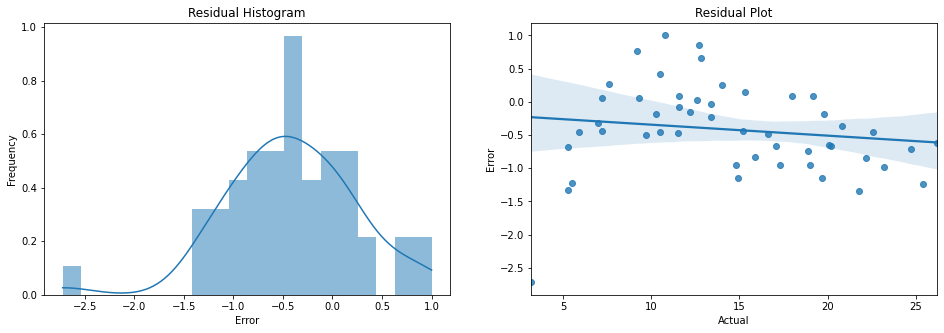

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

h = sns.histplot(linreg.resid, bins=20, kde=True, stat="density", linewidth=0, ax=axes[0])
h.set(title='Residual Histogram')
h.set_xlabel("Error")
h.set_ylabel("Frequency")

s = sns.regplot(x=linreg.y_test, y=linreg.resid, ax=axes[1])
s.set(title='Residual Plot')
s.set_xlabel("Actual")
s.set_ylabel("Error")

plt.show()

### The histogram is approximately normally distributed with a center at nearly 0, which is a requirement for linear regression. The points on our residual plot, on the other hand, are not completely randomly dispersed. This indicates that the relationship between Sales and the predictors used in the model is not perfectly linear - which is to be somewhat expected. 

### While there is defintely a discernible pattern in our residual plot, our OLS Regression is still a very good model for this data. This model achieved an R-squared score of .982, meaning that more than 98% of the variance in our response varaible can be explained by our predictors. A non-linear model likely would have performed marginally better, but the OLS Regression model is easy to interpret and explain - which is extremely important in the real world, especialy when trying to decide how to spend a marketing budget. 

## Budget Optimization

### In our original model, we scaled our predictors to make our coefficients more readable and improve the efficiency of our model. However, if we want to predict sales given certain values for TV and Radio spending, we need to run the model on our unscaled data to get the proper coefficients. This won't change the predictive power of our model in any way.

In [99]:
linreg(df2)
betas = np.around(np.array(linreg.coefs), decimals=6)
vars = list(df2.columns)
print(f'Regression Function: {vars[-1]} = {betas[0]} + {betas[1]}({vars[0]}) + {betas[2]}({vars[1]}) + {betas[3]}({vars[2]}) + {betas[4]}({vars[3]})')

Regression Function: sales = 5.525604 + 0.047724(tv) + 0.027215(radio) + -0.000104(tv*tv) + 0.001108(tv*radio)


### Now that we have our regression function, we are going to maximize predicted sales given a budget of $250 (thousand). Here, we are only concerned with TV and Radio advertising because we could not reject the null hypothesis that the coefficient for Newspaper advertising in the regression equation was equal to 0.

In [100]:
# initialize our budget as well as our objective and constraint functions
max_budget = 250

def objective(x):
    x1 = x[0]
    x2 = x[1]
    variables = np.array([1, x1, x2, x1**2, x1*x2])
    coefs = np.array(linreg.coefs)
    obj = -np.dot(variables, coefs)
    
    return obj

def constraint(x):
    return max_budget - x[0] - x[1]

In [101]:
x0 = np.zeros(2)
b = (0.0, 250.0)
bounds = (b, b)
con = {'type': 'ineq', 'fun': constraint}
solution = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=con)

In [102]:
print(f'The company should spend ${1000*int(solution["x"][0])} on TV advertising and ${1000*int(solution["x"][1])} on Radio advertising.')
print(f'The predicted value for sales with this budget breakdown is ${1000000*int(-solution["fun"])}.')

The company should spend $122000 on TV advertising and $127000 on Radio advertising.
The predicted value for sales with this budget breakdown is $30000000.
